# All PyZX Features

## Contents:
* [Loading and saving circuits](#circuits)
* [Importing, exporting and editing diagrams](#diagram-io)
* [Optimizing ZX-diagrams](#optimization-zx)
* [Extracting and optimizing circuits](#optimization-circuits)
* [Phase Teleportation](#phase-teleportation)
* [Routing Circuits](#routing)

In [1]:
import sys; sys.path.insert(0,'..')
import random, math, os
import pyzx as zx
from fractions import Fraction

<a id="circuits"></a>
# Loading and saving circuits
The most straightforward way to load a circuit is to use ``zx.Circuit.load`` which tries to figure out in which file format the circuit is given. The supported file formats are QASM, QC and the Quipper ASCII format. The corresponding loading functions are:
* ``zx.Circuit.from_qasm_file``
* ``zx.Circuit.from_quipper_file``
* ``zx.Circuit.from_qc_file``

In [2]:
fname = os.path.join('..','circuits','Fast', 'mod5_4_before')
circ = zx.Circuit.load(fname)
# Alternatively we could have done:
# circ = zx.Circuit.from_quipper_file(fname)
circ.gates

[NOT(4),
 HAD(4),
 CCZ(c1=0,c2=3,t=4),
 CCZ(c1=2,c2=3,t=4),
 HAD(4),
 CNOT(3,4),
 HAD(4),
 CCZ(c1=1,c2=2,t=4),
 HAD(4),
 CNOT(2,4),
 HAD(4),
 CCZ(c1=0,c2=1,t=4),
 HAD(4),
 CNOT(1,4),
 CNOT(0,4)]

As you can see, a circuit is essentially a list of gates (objects of type zx.circuit.Gate). We can draw the circuit using zx.draw():

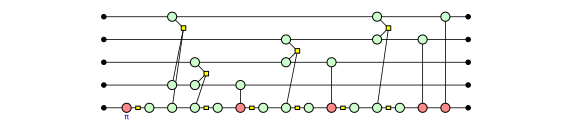

In [3]:
zx.draw_matplotlib(circ, figsize=(10,2), h_edge_draw='box')

The CCZ gates are drawn in [ZH](https://arxiv.org/abs/1805.02175) notation by default. We can get a pure ZX-diagram if we first convert the circuit to basic (i.e. Clifford+T) gates:

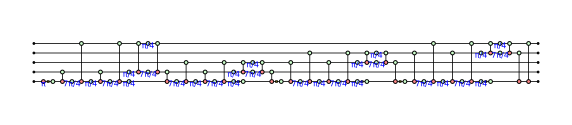

In [4]:
zx.draw_matplotlib(circ.to_basic_gates(), figsize=(10,2), h_edge_draw='box')

Here we've drawn the circuit using the Matplotlib backend, but we can also use the D3 Javascript library to generate a more interactive representation:

In [5]:
zx.draw(circ)

We can ask for simple statistics for this circuit:

In [6]:
print(circ.stats())

Circuit mod5_4_before on 5 qubits with 15 gates.
        28 is the T-count
        11 Cliffords among which
        4 2-qubit gates (4 CNOT, 0 other) and
        6 Hadamard gates.
There are 4 gates of a different type


Note that a lot of the circuit is hidden in the mysterious "4 gates of a different type" (which are the CCZ gates). We can write the circuit in terms of basic gates to get more accurate Clifford+T statistics:

In [7]:
print(circ.to_basic_gates().stats())

Circuit mod5_4_before on 5 qubits with 63 gates.
        28 is the T-count
        35 Cliffords among which
        28 2-qubit gates (28 CNOT, 0 other) and
        6 Hadamard gates.


A Circuit can be exported into the supported file formats using
    * ``circ.to_qasm``
    * ``circ.to_quipper``
    * ``circ.to_qc``

In [8]:
print(circ.to_qasm())

OPENQASM 2.0;
include "qelib1.inc";
qreg q[5];
x q[4];
h q[4];
ccz q[0], q[3], q[4];
ccz q[2], q[3], q[4];
h q[4];
cx q[3], q[4];
h q[4];
ccz q[1], q[2], q[4];
h q[4];
cx q[2], q[4];
h q[4];
ccz q[0], q[1], q[4];
h q[4];
cx q[1], q[4];
cx q[0], q[4];



In [9]:
print(circ.to_quipper())

Inputs: 0:Qbit, 1:Qbit, 2:Qbit, 3:Qbit, 4:Qbit
QGate["not"](4) with nocontrol
QGate["H"](4) with nocontrol
QGate["Z"](4) with controls=[+0,+3] with nocontrol
QGate["Z"](4) with controls=[+2,+3] with nocontrol
QGate["H"](4) with nocontrol
QGate["not"](4) with controls=[+3] with nocontrol
QGate["H"](4) with nocontrol
QGate["Z"](4) with controls=[+1,+2] with nocontrol
QGate["H"](4) with nocontrol
QGate["not"](4) with controls=[+2] with nocontrol
QGate["H"](4) with nocontrol
QGate["Z"](4) with controls=[+0,+1] with nocontrol
QGate["H"](4) with nocontrol
QGate["not"](4) with controls=[+1] with nocontrol
QGate["not"](4) with controls=[+0] with nocontrol
Outputs: 0:Qbit, 1:Qbit, 2:Qbit, 3:Qbit, 4:Qbit


In [10]:
print(circ.to_qc())

.v q0 q1 q2 q3 q4

BEGIN
X q4
H q4
Z q0 q3 q4
Z q2 q3 q4
H q4
Tof q3 q4
H q4
Z q1 q2 q4
H q4
Tof q2 q4
H q4
Z q0 q1 q4
H q4
Tof q1 q4
Tof q0 q4
END



<a id="diagram-io"></a>
# Importing, exporting and editing diagrams
PyZX also has its own json format for exporting graphs and interacts with [ZXLive](https://github.com/zxcalc/zxlive) to make manually modifying diagrams easy. First, let's see that we can indeed load diagrams:

In [15]:
fname = os.path.join('..','circuits','2-qubit-unitary.zxg')
with open(fname, 'r') as f:
    g = zx.Graph.from_json(f.read())
zx.draw(g, labels=True)

Because this graph was originally exported from PyZX starting as a circuit, it has automatically remembered what its inputs and outputs are:

In [16]:
g.inputs(), g.outputs()

((12, 10), (9, 11))

For a graph that was built manually, we might need to tell it what its inputs and outputs are.

This can be done either manually:

    g.set_inputs(tuple_of_inputs); g.set_outputs(tuple_of_outputs)
    
or by PyZX through calling ``g.auto_detect_io()``. This function makes all boundaries pointing to the right inputs, and those pointing to the left inputs. For example:

In [17]:
g.set_inputs(()) # Reset the inputs and outputs, so we can let PyZX auto-detect them
g.set_outputs(())
g.auto_detect_io()
print(g.inputs(), g.outputs())

(12, 10) (9, 11)


we can export a diagram to a JSON format that can be loaded back into PyZX (or ZXLive):

In [18]:
print(g.to_json())

{"version": 2, "backend": "simple", "variable_types": {}, "scalar": {"power2": 0, "phase": "0"}, "inputs": [12, 10], "outputs": [9, 11], "edata": {}, "vertices": [{"id": 0, "t": 2, "pos": [4, -1], "data": {"name": "v4"}}, {"id": 1, "t": 2, "pos": [3, -1], "data": {"name": "v10"}}, {"id": 2, "t": 1, "pos": [3, -2], "phase": "\u03c0/4", "data": {"name": "v11"}}, {"id": 3, "t": 1, "pos": [1, 1], "data": {"name": "v2"}}, {"id": 4, "t": 1, "pos": [1, 2], "data": {"name": "v1"}}, {"id": 5, "t": 1, "pos": [4, -2], "phase": "\u03c0/4", "data": {"name": "v5"}}, {"id": 6, "t": 2, "pos": [2, -1], "data": {"name": "v7"}}, {"id": 7, "t": 1, "pos": [4.25, 1.5], "phase": "7\u03c0/4", "data": {"name": "v9"}}, {"id": 8, "t": 1, "pos": [2, -2], "phase": "\u03c0/4", "data": {"name": "v8"}}, {"id": 9, "t": 0, "pos": [7, 1], "data": {"name": "b2"}}, {"id": 10, "t": 0, "pos": [0, 2], "data": {"name": "b8"}}, {"id": 11, "t": 0, "pos": [7, 2], "data": {"name": "b3"}}, {"id": 12, "t": 0, "pos": [0, 1], "data":

We can call ZXLive from within a Jupyter notebook, in order to modify diagrams on the fly:

In [69]:
%gui qt6

# First make sure zxlive is installed by `pip install zxlive`
from zxlive import app

g =  zx.Graph()
g.add_vertex(zx.VertexType.Z, 0, 0)
g.add_vertex(zx.VertexType.X, 0, 1)
g.add_edge((0, 1))
zx.draw(g)

zxl = app.get_embedded_app()
zxl.edit_graph(g, 'g1')
zxl.edit_graph(g, 'g2')

ERROR:root:
    Could not load requested Qt binding. Please ensure that
    PyQt4 >= 4.7, PyQt5, PyQt6, PySide >= 1.0.3, PySide2, or
    PySide6 is available, and only one is imported per session.

    Currently-imported Qt library:                              None
    PyQt5 available (requires QtCore, QtGui, QtSvg, QtWidgets): False
    PyQt6 available (requires QtCore, QtGui, QtSvg, QtWidgets): False
    PySide2 installed:                                          False
    PySide6 installed:                                          False
    Tried to load:                                              ['pyqt6']
    


ModuleNotFoundError: No module named 'zxlive'

After making some edits within ZXLive, we can get the diagram back into this window so we can continue to do further work with them:

In [70]:
zx.draw(zxl.get_copy_of_graph('g1'))
zx.draw(zxl.get_copy_of_graph('g2'))
#Note that ZXLive only works with MultiGraph's, and hence zxl.get_copy_of_graph() always returns an instance of MultiGraph, 
#and not of the default graph backend.

NameError: name 'zxl' is not defined

<a id="optimization-zx"></a>
# Optimizing ZX-diagrams
PyZX contains many functions for optimizing circuits and ZX-diagrams. In this section we will show how these methods work and can be called.

First, let us load a small circuit:

In [49]:
fname = os.path.join('..','circuits','Fast', 'mod5_4_before')
circ = zx.Circuit.load(fname).to_basic_gates()
print("original T-count:", zx.tcount(circ))
zx.draw(circ)

original T-count: 28


The most basic simplification routine for ZX-graphs is ``interior_clifford_simp``. This uses the simplification rules based on spider-fusion, identity removal, pivoting and local complementation until they cannot be applied anymore.

In [50]:
g = circ.to_graph() # We first have to convert the circuit into a ZX-graph
zx.simplify.interior_clifford_simp(g)
# The following function makes the representation of the graph more compact. 
# It only moves vertices around, and may introduce some identities
# It is recommended to call this function before trying to draw a graph, as otherwise the graph might not be very readable.
g.normalize() 
zx.draw(g)
print("Optimized T-count:", zx.tcount(g))

Optimized T-count: 22


As you can see this routine has decreased the T-count by a bit, but not by a lot.


Part of the reason is that in this circuit there are still a few phaseless nodes 'trapped' in the middle of the circuit. These nodes are however connected to the boundary, so if we unfuse those boundary nodes we can get rid of the interior nodes. This can be done by calling ``zx.simplify.pivot_boundary_simp``. As this function changes the graph, we call ``interior_clifford_simp`` afterwards to do whatever new simplifications have become available.

In [51]:
zx.simplify.pivot_boundary_simp(g)
zx.draw(g)
zx.simplify.interior_clifford_simp(g)
g.normalize()
zx.draw(g)
print("Optimized T-count:", zx.tcount(g))

Optimized T-count: 22


Though the graph is smaller now, it hasn't decreased the T-count any further in this case.

The method ``clifford_simp`` is a convenience function that calls ``interior_clifford_simp`` and ``pivot_boundary_simp`` until no further simplifications are found. It is recommended that you call ``clifford_simp`` instead of the other functions.
In order to further reduce the T-count we have to start using more advanced techniques. Namely the process of *gadgetization*:

In [52]:
zx.simplify.pivot_gadget_simp(g)
zx.draw(g)
print("T-count:", zx.tcount(g))

T-count: 22


This method combines all T-like phases with a phaseless spider to turn it into a *phase gadget*. In the previous diagram those are the spider pairs floating above the rest of the diagram, which we refer to as its *skeleton*. As you can see, the T-count has not actually been reduced by doing just these pivots, but now the graph has a completely different structure then before, so lets see what happens if we apply ``clifford_simp`` again:

In [53]:
zx.simplify.clifford_simp(g)
g.normalize()
zx.draw(g)
print("Optimized T-count:", zx.tcount(g))

Optimized T-count: 16


That has reduced the T-count from 22 down to 16!

But we are in fact not done yet. If you look closely at the graph above you will see that a few of the gadgets have exactly the same set of neighbors. Whenever this happens, these phase gadgets can be fused into a single phase gadget by adding the phases together. This procedure is done by ``gadget_simp``:

In [54]:
zx.simplify.gadget_simp(g)
g.normalize()
zx.draw(g)
print("Optimized T-count:", zx.tcount(g))

Optimized T-count: 14


Since it is quite a bit of effort to do all these steps manually, they have been combined into the function ``full_reduce``. This procedure does the following steps:

 1. Run ``clifford_simp``.
 2. Gadgetize the diagram using ``pivot_gadget_simp``.
 4. Run ``clifford_simp``.
 5. Run ``gadget_simp``. If it finds simplifications go back to step 1, otherwise halt.
 
To demonstrate:

In [55]:
g = circ.to_basic_gates().to_graph()
zx.simplify.full_reduce(g)
g.normalize()
zx.draw(g)
print("Final T-count:", zx.tcount(g))

Final T-count: 8


We managed to reduce the T-count from 28 to just 8!

The next step is to turn this graph back into a circuit

<a id="optimization-circuits"></a>
# Extracting and optimizing circuits

For extracting circuits out of ZX-graphs there is only a single method in PyZX that you have to call: ``zx.extract_circuit``. This method should always work *when dealing with graphs produced by ``full_reduce``.* There is no guarantee that it can extract circuits from arbitrary ZX-diagrams.

Let's see what this method does when applied to the circuit from the previous section:

In [39]:
fname = os.path.join('..','circuits','Fast', 'mod5_4_before')
circ = zx.Circuit.load(fname).to_basic_gates()
print("The original circuit:")
zx.draw(circ)

g = circ.to_graph()
zx.simplify.full_reduce(g)
g.normalize()
print("The optimized ZX-diagram:")
zx.draw(g)

new_circ = zx.extract_circuit(g)
print("The extracted circuit:")
zx.draw(new_circ)

The original circuit:


The optimized ZX-diagram:


The extracted circuit:


Explaining how ``extract_circuit`` works is out of scope for this notebook for now. If you want to know more you can check out the paper [Graph-theoretic Simplification of Quantum Circuits with the ZX-calculus](https://arxiv.org/abs/1902.03178) or the more recent (but more involved) [There and back again: A circuit extraction tale](https://arxiv.org/abs/2003.01664).

As you can see, the extracted circuit looks quite different from the original circuit, so how can we be sure that they actually represent the same unitary? PyZX allows you to convert ZX-diagrams into the tensors they represent using numpy. In this way we can directly compare the unitaries and see that they are equal:

In [40]:
# This method checks whether the two given ZX-graphs or circuits have the same tensor representation up to some nonzero scalar
zx.compare_tensors(circ, new_circ)

True

This method uses ``zx.tensorfy`` under the hood to turn the circuits into tensors. There are different strategies available for the simulation, whose performances depend heavily on the circuit structure. For a detailed comparison, refer to the method's documentation and `demos/BenchmarkTensorContraction` notebook.

PyZX also offers a different method to check whether two circuits are equal:

In [41]:
circ.verify_equality(new_circ)

True

This method takes the composition of the first circuit with the adjoint of the second and simplifies the resulting circuit with ``full_reduce``. If it succeeds, it returns ``True``, if it does not it returns ``False``. This means that if this method succeeds, that is very likely that the 2 circuits are equal (it would be very unlikely that some bug in the rewriting engine would cancel out in exactly the right way to be able to reduce the circuit to the identity). However, if it returns ``False`` it might simply mean that the rewrite engine is not powerful enough to verify the equality of the two circuits.

``extract_circuit`` often produces circuits that are clearly not optimal as can be seen in the series of Hadamard gates at the end of the above extracted circuit. PyZX offers a circuit optimization method that takes care of this obvious kind of suboptimality:

In [43]:
print(new_circ.to_basic_gates().stats())
optimized_circ = zx.optimize.basic_optimization(new_circ.to_basic_gates(),do_swaps=True).to_basic_gates()
print(optimized_circ.stats())
zx.draw(optimized_circ)

Circuit  on 5 qubits with 68 gates.
        8 is the T-count
        60 Cliffords among which
        28 2-qubit gates (6 CNOT, 22 other) and
        30 Hadamard gates.
Circuit  on 5 qubits with 36 gates.
        8 is the T-count
        28 Cliffords among which
        26 2-qubit gates (25 CNOT, 1 other) and
        2 Hadamard gates.


``basic_optimization`` commutes gates past Hadamards in order to find matching CNOT, CZ and Hadamard gates that can be cancelled. Depending on the circuit it can find significant reductions in the amount of Hadamard gates, which is useful for the next optimization routine. Note that we gave it the argument `do_swaps=True`. This allows it to use a more powerful optimization technique involving transforming adjacent CNOT gates into SWAPs. While for larger circuits this often leads to better results, for smaller circuits it can also increase the gate-count (due to the cost of the SWAP gates at the end of the circuits).

As you can see, the optimized circuit only contains 2 Hadamard gates, and in fact the leftmost Hadamard gate could be commuted past the CNOTs and CZs to its left so that the entire interior of the circuit is free of Hadamards. Such a Hadamard-free circuit is called a *phase polynomial* circuit, and there are specific techniques for optimizing these types of circuits. PyZX offers a method that finds phase polynomial sub-circuits and runs an optimization routine on them:

In [44]:
final_circ = zx.optimize.phase_block_optimize(optimized_circ).to_basic_gates()
final_circ = zx.optimize.basic_optimization(final_circ) # We call this again, as it does some extra processing
print(final_circ.stats())
zx.draw(final_circ)

Circuit  on 5 qubits with 31 gates.
        8 is the T-count
        23 Cliffords among which
        18 2-qubit gates (16 CNOT, 2 other) and
        2 Hadamard gates.


Let's check once more that this circuit is still equal to the original circuit:

In [45]:
zx.compare_tensors(circ, final_circ)

True

Note that here we could not use `circ.verify_equality` as the optimisations using in `phase_block_optimize` do transformations to the circuit that are not compatible with `verify_equality`.

And finally lets output this circuit in a format that is usable in other software:

In [46]:
print(final_circ.to_qasm())

OPENQASM 2.0;
include "qelib1.inc";
qreg q[5];
rz(0.5*pi) q[0];
cz q[0], q[1];
cz q[1], q[2];
rz(0.5*pi) q[2];
cx q[3], q[2];
h q[4];
rz(0.75*pi) q[2];
cx q[3], q[0];
cx q[4], q[2];
rz(0.75*pi) q[0];
rz(0.25*pi) q[2];
cx q[1], q[2];
cx q[3], q[2];
cx q[4], q[0];
rz(0.25*pi) q[0];
cx q[1], q[0];
rz(0.25*pi) q[2];
cx q[3], q[0];
cx q[4], q[1];
cx q[4], q[2];
rz(0.25*pi) q[0];
rz(0.25*pi) q[2];
cx q[4], q[0];
rz(0.25*pi) q[0];
cx q[2], q[0];
cx q[1], q[2];
cx q[4], q[2];
cx q[2], q[0];
cx q[4], q[1];
h q[4];
z q[1];



<a id="phase-teleportation"></a>
# Phase teleportation

The above procedure of simplifying a diagram, and extracting a new circuit directly from it worked quite well in the example given above, but unfortunately in other cases it can actually *increase* the total gate-count (although it never increases the amount of T-gates).

To get around this issue PyZX offers the *phase teleportation* routine. This uses the diagrammatic simplification only as information to inform when phase gates can be combined in the original circuit, but otherwise it leaves the circuit intact. The details can be found in [Reducing T-count with the ZX-calculus](https://arxiv.org/abs/1903.10477).

In [47]:
fname = os.path.join('..','circuits','Fast', 'mod5_4_before')
circ = zx.Circuit.load(fname).to_basic_gates()
print("The original circuit:")
zx.draw(circ)
g = zx.simplify.teleport_reduce(circ.to_graph())
print("Circuit after phase teleportation:")
zx.draw(g)

The original circuit:


Circuit after phase teleportation:


As you can see the circuit is exactly the same, except that it has less phase gates. Let's verify that it is indeed still the same circuit:

In [48]:
zx.compare_tensors(circ, g)

True

# Local Search

We can apply techniques like Genetic Algorithms and Simulated Annealing to search the local space of a ZX diagram for equivalent diagrams that might have more efficient circuit extractions. 

In [88]:
N_QUBITS = 5
DEPTH = 100
c = zx.generate.CNOT_HAD_PHASE_circuit(qubits=N_QUBITS, depth=DEPTH, clifford=False)
print(f"Before local search")
print(c.stats())
g = c.to_graph()
zx.full_reduce(g)

ga_opt = zx.GeneticOptimizer()
g_evolve = ga_opt.evolve(g, n_mutants=20, n_generations=40, quiet=False)
zx.full_reduce(g_evolve)
c_evolve = zx.extract_circuit(g_evolve.copy()).to_basic_gates()
c_evolve = zx.basic_optimization(c_evolve)
print(f'After local search ')
print(c_evolve.stats())

Before local search
Circuit  on 5 qubits with 100 gates.
        19 is the T-count
        81 Cliffords among which
        61 2-qubit gates (61 CNOT, 0 other) and
        20 Hadamard gates.


Generations: 100%|██████████| 40/40 [00:05<00:00,  7.44it/s]

After local search 
Circuit  on 5 qubits with 55 gates.
        15 is the T-count
        40 Cliffords among which
        31 2-qubit gates (26 CNOT, 5 other) and
        6 Hadamard gates.


# Routing Quantum Circuits

This section demonstrates how to route quantum circuits to specific hardware architectures using PyZX.  

Routing transforms a logical circuit, which may contain long-range gates not directly supported by hardware, into an equivalent circuit that respects the connectivity constraints of the target architecture.

We show how to route a 5-qubit circuit to:
- A linear (line) architecture
- The IBM QX4 quantum processor

The routing uses the Gray synthesis method and optionally the Gray-Meijer combined method for more constrained layouts.


In [89]:
from fractions import Fraction
import pyzx as zx
from pyzx.routing import create_architecture, route_phase_poly, RoutingMethod, ElimMode

# Create a logical circuit to route
circ = zx.Circuit(5)
circ.add_gate("CNOT", 0, 4)
circ.add_gate("CNOT", 1, 3)
circ.add_gate("CNOT", 4, 2)
circ.add_gate("CNOT", 2, 0)
circ.add_gate("CNOT", 3, 1)
circ.add_gate("CNOT", 0, 1)
circ.add_gate("ZPhase", 0, Fraction(1, 4))
circ.add_gate("ZPhase", 2, Fraction(1, 2))
circ.add_gate("ZPhase", 3, Fraction(3, 4))
circ.add_gate("ZPhase", 4, Fraction(1, 8))

# Define architectures
line_arch = create_architecture('line', n_qubits=5)
ibm_arch = create_architecture('ibm_qx4')

# Route the circuit
routed_line = route_phase_poly(circ, line_arch, method=RoutingMethod.GRAY, mode=ElimMode.STEINER_MODE)
routed_ibm = route_phase_poly(circ, ibm_arch, method=RoutingMethod.GRAY_MEIJER, mode=ElimMode.STEINER_MODE)

# Print stats
print("Original Circuit Stats:")
print(circ.stats())
print("\nRouted on Line Architecture:")
print(routed_line.stats())
print("\nRouted on IBM QX4 Architecture:")
print(routed_ibm.stats())



Original Circuit Stats:
Circuit  on 5 qubits with 10 gates.
        3 is the T-count
        7 Cliffords among which
        6 2-qubit gates (6 CNOT, 0 other) and
        0 Hadamard gates.

Routed on Line Architecture:
Circuit  on 5 qubits with 46 gates.
        3 is the T-count
        43 Cliffords among which
        42 2-qubit gates (42 CNOT, 0 other) and
        0 Hadamard gates.

Routed on IBM QX4 Architecture:
Circuit  on 5 qubits with 28 gates.
        3 is the T-count
        25 Cliffords among which
        24 2-qubit gates (24 CNOT, 0 other) and
        0 Hadamard gates.


# Laying out diagrams

Sometimes you might have a diagram that does not contain information on how to lay it out nice graphically, or the simplifications mess it up enough that it does not look nice any more. PyZX has an auto-layout feature to deal with those cases.

First, we generate diagram representing a stabiliser state preparation by post-selecting on circuits projectors, and then we simplify this diagram and lay it out.

In [57]:
c = zx.Circuit(0)
for i in range(7): c.add_gate("InitAncilla", i)
for i in range(7): c.add_gate("HAD", i)

c.add_gate("InitAncilla", 7)
c.add_gate("CNOT", 7, 0)
c.add_gate("CNOT", 7, 1)
c.add_gate("CNOT", 7, 2)
c.add_gate("CNOT", 7, 3)
c.add_gate("PostSelect", 7)

c.add_gate("InitAncilla", 7)
c.add_gate("CNOT", 7, 0)
c.add_gate("CNOT", 7, 1)
c.add_gate("CNOT", 7, 4)
c.add_gate("CNOT", 7, 5)
c.add_gate("PostSelect", 7)

c.add_gate("InitAncilla", 7)
c.add_gate("CNOT", 7, 0)
c.add_gate("CNOT", 7, 2)
c.add_gate("CNOT", 7, 4)
c.add_gate("CNOT", 7, 6)
c.add_gate("PostSelect", 7)

print(c.gates)
zx.draw(c)

[InitAncilla(0), InitAncilla(1), InitAncilla(2), InitAncilla(3), InitAncilla(4), InitAncilla(5), InitAncilla(6), HAD(0), HAD(1), HAD(2), HAD(3), HAD(4), HAD(5), HAD(6), InitAncilla(7), CNOT(7,0), CNOT(7,1), CNOT(7,2), CNOT(7,3), PostSelect(7), InitAncilla(7), CNOT(7,0), CNOT(7,1), CNOT(7,4), CNOT(7,5), PostSelect(7), InitAncilla(7), CNOT(7,0), CNOT(7,2), CNOT(7,4), CNOT(7,6), PostSelect(7)]


In [58]:
g = c.to_graph()
zx.full_reduce(g)
zx.to_rg(g)
zx.draw(g)

In [59]:
random.seed(101)
zx.draw(g, auto_layout=True)